In [1]:
!pip install stellargraph

In [2]:
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

In [3]:
dataset = datasets.PROTEINS()
display(HTML(dataset.description))
graphs, graph_labels = dataset.load()

In [4]:
print(graphs[0].info())

StellarGraph: Undirected multigraph
 Nodes: 42, Edges: 162

 Node types:
  default: [42]
    Features: float32 vector, length 4
    Edge types: default-default->default

 Edge types:
    default-default->default: [162]
        Weights: all 1 (default)
        Features: none


In [5]:
print(graphs[1].info())

StellarGraph: Undirected multigraph
 Nodes: 27, Edges: 92

 Node types:
  default: [27]
    Features: float32 vector, length 4
    Edge types: default-default->default

 Edge types:
    default-default->default: [92]
        Weights: all 1 (default)
        Features: none


In [6]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,1113.0,1113.0
mean,39.1,145.6
std,45.8,169.3
min,4.0,10.0
25%,15.0,56.0
50%,26.0,98.0
75%,45.0,174.0
max,620.0,2098.0


In [7]:
graph_labels.value_counts().to_frame()

,label
1,663
2,450


In [8]:
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

In [9]:
generator = PaddedGraphGenerator(graphs=graphs)

Create the Keras graph classification model

In [10]:
k = 35  # the number of rows for the output tensor
layer_sizes = [32, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh"],
    k=k,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

Instructions for updating:
Use fn_output_signature instead


In [11]:
x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

In [12]:
model = Model(inputs=x_inp, outputs=predictions)

model.compile(
    optimizer=Adam(lr=0.0001), loss=binary_crossentropy, metrics=["acc"],
)

In [13]:
train_graphs, test_graphs = model_selection.train_test_split(
    graph_labels, train_size=0.9, test_size=None, stratify=graph_labels,
)

In [14]:
gen = PaddedGraphGenerator(graphs=graphs)

train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    batch_size=50,
    symmetric_normalization=False,
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    batch_size=1,
    symmetric_normalization=False,
)

In [15]:
epochs = 100

In [16]:
history = model.fit(
    train_gen, epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True,
)


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


21/21 [==============================] - 5s 154ms/step - loss: 0.6529 - acc: 0.5863 - val_loss: 0.6332 - val_acc: 0.5982
Epoch 2/100
21/21 [==============================] - 3s 123ms/step - loss: 0.6265 - acc: 0.6055 - val_loss: 0.6255 - val_acc: 0.6429
Epoch 3/100
21/21 [==============================] - 3s 101ms/step - loss: 0.6104 - acc: 0.6956 - val_loss: 0.6187 - val_acc: 0.6875
Epoch 4/100
21/21 [==============================] - 2s 120ms/step - loss: 0.5942 - acc: 0.7044 - val_loss: 0.6139 - val_acc: 0.6786
Epoch 5/100
21/21 [==============================] - 2s 119ms/step - loss: 0.5808 - acc: 0.7326 - val_loss: 0.6131 - val_acc: 0.6875
Epoch 6/100
21/21 [==============================] - 3s 101ms/step - loss: 0.5803 - acc: 0.7372 - val_loss: 0.6036 - val_acc: 0.6875
Epoch 7/100
21/21 [==============================] - 3s 118ms/step - loss: 0.5742 - acc: 0.7245 - val_loss: 0.6009 - val_acc: 0.6875
Epoch 8/100
21/21 [==============================] - 2s 121ms/step - loss: 0.5712

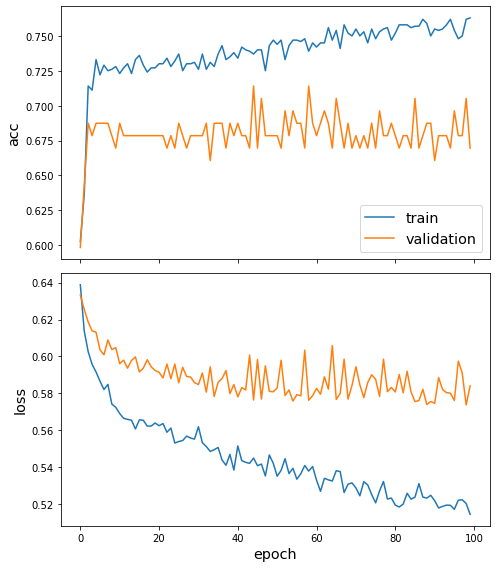

In [17]:
sg.utils.plot_history(history)

In [18]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

112/112 [==============================] - 0s 2ms/step - loss: 0.5841 - acc: 0.6696

Test Set Metrics:
	loss: 0.5841
	acc: 0.6696
